# Logistic Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use('arviz-darkgrid')

## Load and examine American National Election Studies (ANES) data
These data are from the 2016 pilot study. The full study consisted of 1200 people, but here we've selected the subset of 487 people who responded to a question about whether they would vote for Hillary Clinton or Donald Trump. 

In [3]:
data = pd.read_csv('data/ANES_2016_pilot.csv')
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is `vote`, which gives peoples' responses to the following question prompt:

_"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"_

In [4]:
data['vote'].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

The two predictors we'll examine are a respondent's `age` and their political party affiliation, `party_id`, which is their response to the following question prompt:

_"Generally speaking, do you usually think of yourself as a Republican, a Democrat, an
independent, or what?"_

In [5]:
data['party_id'].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

These two predictors are somewhat correlated, but not all that much:

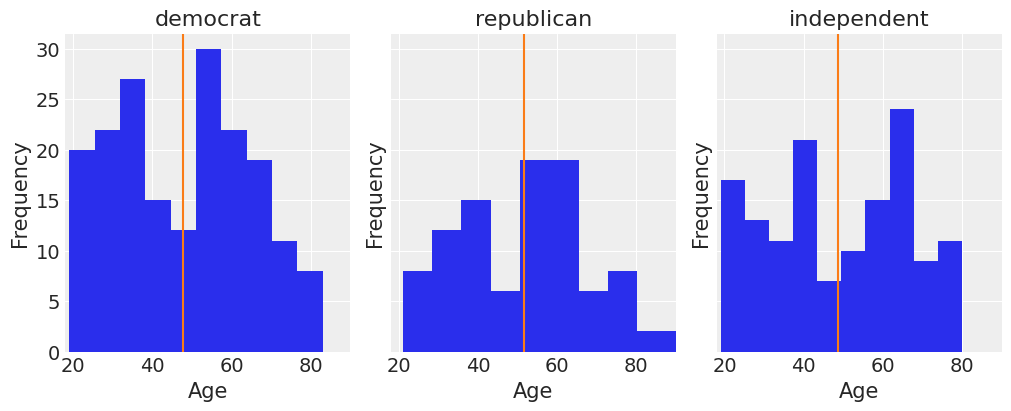

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data['party_id'].unique(), range(3)))
for label, df in data.groupby('party_id'):
    ax[key[label]].hist(df['age'])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel('Age')
    ax[key[label]].set_ylabel('Frequency')
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df['age'].mean(), color='C1')

We can get a pretty clear idea of how party identification is related to voting intentions by just looking at a contingency table for these two variables:

In [7]:
pd.crosstab(data['vote'], data['party_id'])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


But our main question here will be: How is respondent age related to voting intentions, and is this relationship different for different party affiliations? For this we will use a logistic regression.

## Build `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [8]:
clinton_data = data.loc[data['vote'].isin(['clinton', 'trump']), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Specifying and fitting the model is simple. Notice the (optional) syntax that we use on the left-hand-side of the formula: We say `vote[clinton]` to instruct `bambi` that we wish the model the probability that `vote=='clinton'`, rather than the probability that `vote=='trump'`. If we leave this unspecified, `bambi` will just pick one of the events to model, but will inform you which one it picked when you build the model (and again when you look at model summaries).

On the right-hand-side of the formula we use `pary_id + party_id:age` to instruct `bambi` that we want to use `party_id` and the interaction between `party_id` and `age` as the explanatory variables in the model.

When fitting models using the `pymc3` backend, the default estimation strategy is to start with an identity mass matrix, but add uniform jitter in [-1, 1] and then adapt a diagonal based on the variance of the tuning draws. This generally works quite well, but occasionally it can fails. That's what was happening for this particular data set and model, so below we disable the `jitter+adapt_diag` initialization by changing from `init='auto'` (the default) to `init=adapt_diag`, which tells the `pymc3` backend to drop the jitter step.

In [9]:
clinton_model = bmb.Model(clinton_data)
clinton_fitted = clinton_model.fit(
    'vote[clinton] ~ party_id + party_id:age',
    family='bernoulli', draws=1000, init='adapt_diag')

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/bambi/models.py:256: UserWarning: Modeling the probability that vote=='clinton'
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


Since we didn't explicitly set any of the prior distributions for the parameters in the model, `bambi` has chosen sensitive defaults for us. To see how all these priors look like, we just call `Model.plot()`.

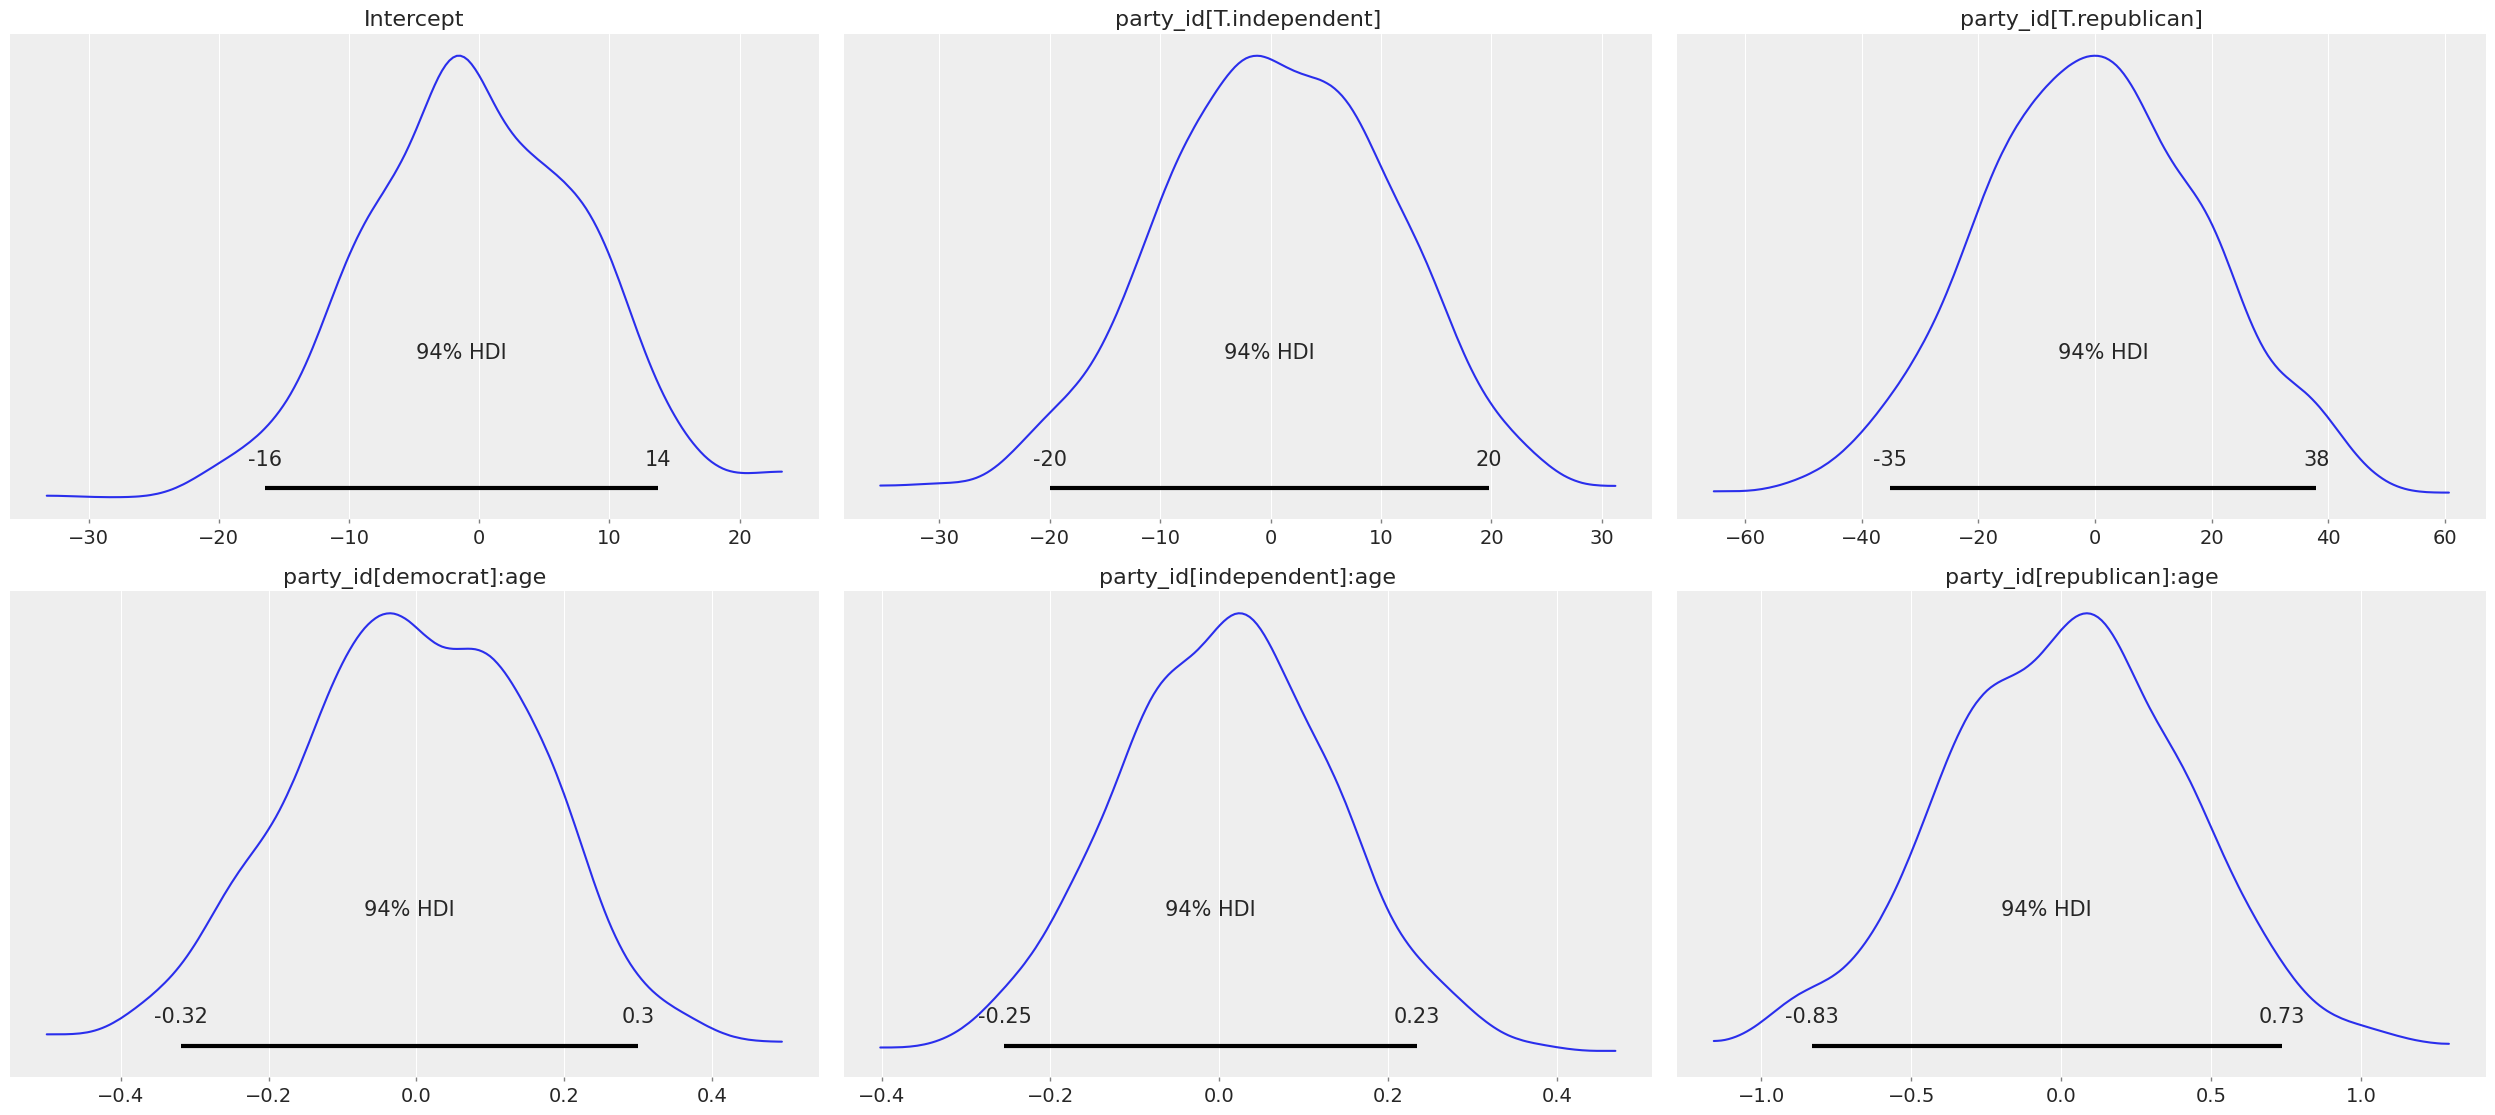

In [10]:
clinton_model.plot();

Here we also inspect the parameters Bambi chosen for each Gaussian.

In [11]:
{x.name: x.prior.args for x in clinton_model.terms.values()}

{'Intercept': {'mu': array([0.308043]), 'sigma': array([8.39859892])},
 'party_id': {'mu': array([0, 0]), 'sigma': array([10.51415445, 18.72417819])},
 'party_id:age': {'mu': array([0, 0, 0]),
  'sigma': array([0.16748696, 0.12909332, 0.40771782])}}

Under the hood, Bambi selected Gaussian priors for all the parameters in the model. We can see that all the priors, except the one for `Intercept`, are centered around 0, which is consistent with the desired weakly informative behavior. However, the standard deviation is specific to each parameter. 

Some more info about these default priors can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Now let's check out the the results! We get traceplots and density estimates for the posteriors with `az.plot_trace()` and a summary of the posteriors with `az.summary()`.

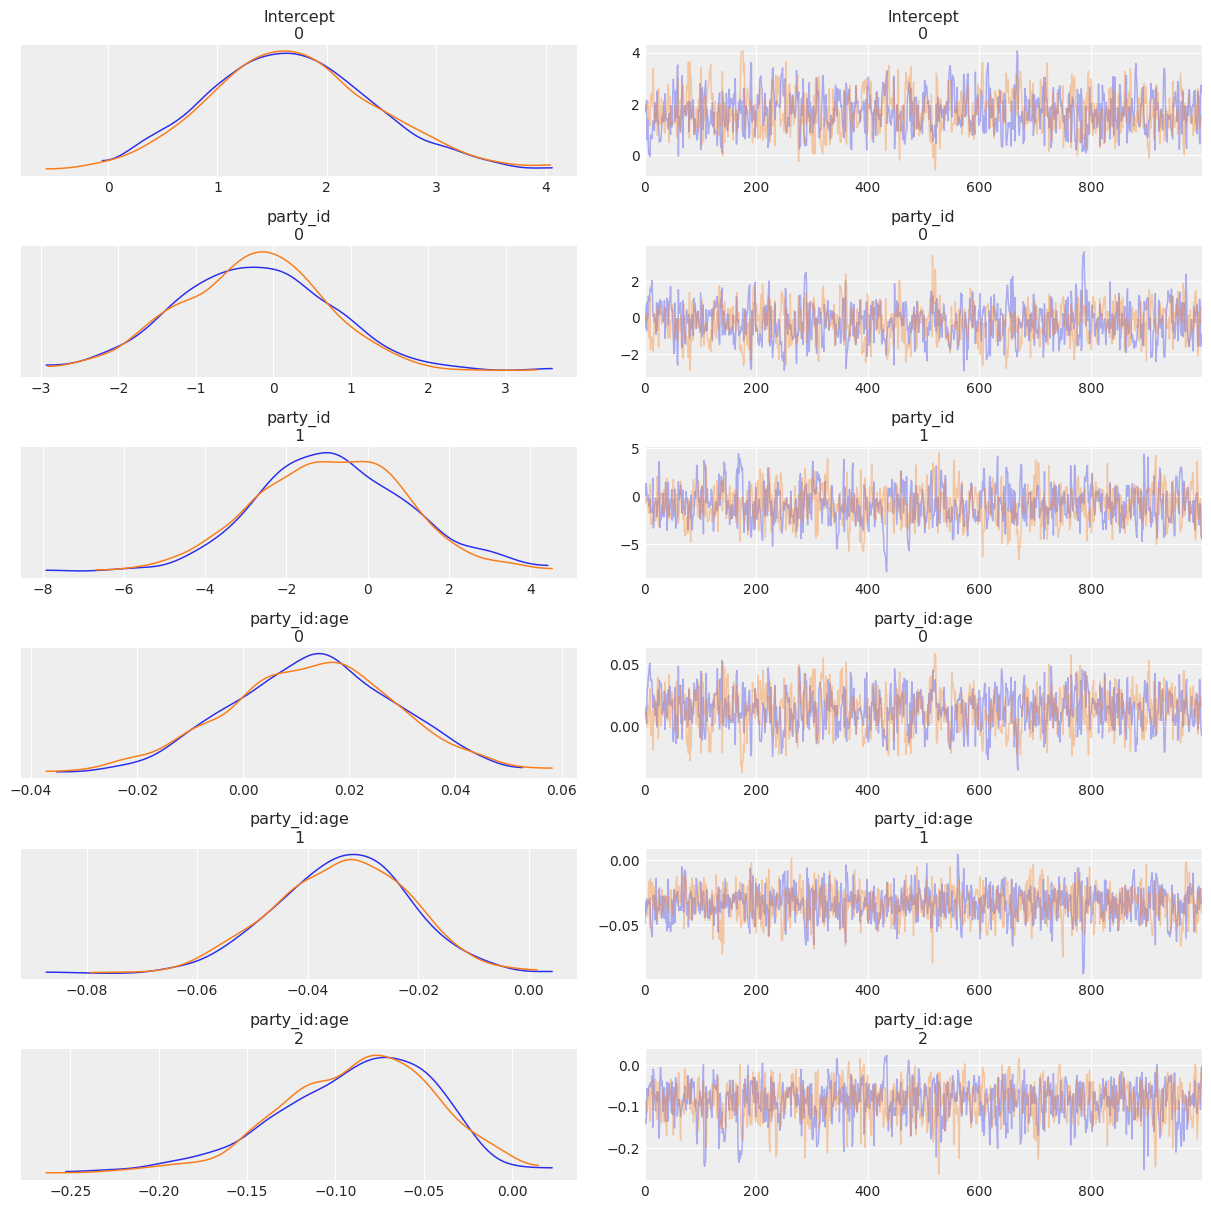

In [12]:
az.plot_trace(clinton_fitted);

In [13]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],1.685,0.742,0.297,3.067,0.029,0.021,653.0,628.0,658.0,687.0,1.0
party_id[0],-0.266,0.953,-1.905,1.652,0.037,0.028,660.0,584.0,668.0,737.0,1.0
party_id[1],-0.872,1.835,-4.316,2.668,0.072,0.052,648.0,624.0,657.0,751.0,1.0
party_id:age[0],0.013,0.015,-0.014,0.043,0.001,0.000,686.0,686.0,686.0,794.0,1.0
party_id:age[1],-0.034,0.012,-0.058,-0.013,0.000,0.000,1107.0,985.0,1136.0,992.0,1.0
party_id:age[2],-0.088,0.045,-0.174,-0.007,0.002,0.001,805.0,717.0,845.0,851.0,1.0


## Run Inference

Grab the posteriors samples of the `age` slopes for the three `party_id` categories.

In [14]:
# We need to automatically add labels to InferenceData object to recover this by_label selection
parties = ['democrat', 'independent', 'republican'] 
party_idx = [0, 1, 2]
dem, ind, rep = [clinton_fitted.posterior['party_id:age'][:,:,x].values
                 for x in party_idx]

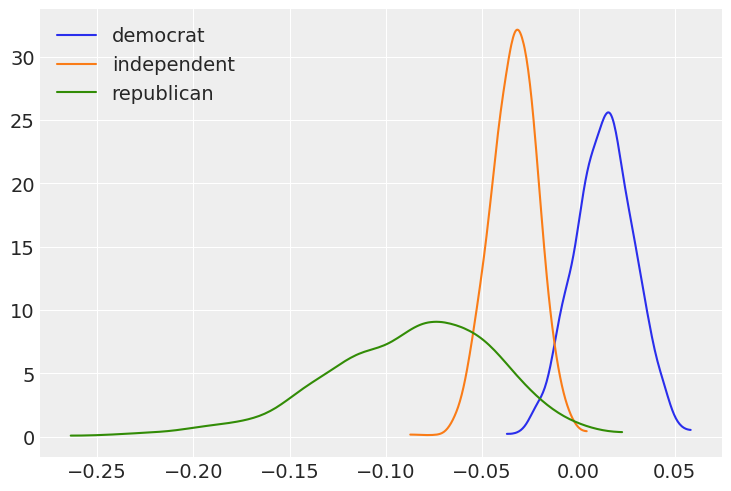

In [15]:
for idx, x in enumerate([dem, ind, rep]):
    ax = az.plot_kde(x, label=f'{parties[idx]}', plot_kwargs={'color':f'C{idx}'})
ax.legend(loc='upper left');

What is the probability that the Democrat slope is greater than the Republican slope?

In [16]:
(dem > rep).mean()

0.992

Probability that the Democrat slope is greater than the Independent slope?

In [17]:
(dem > ind).mean()

0.994

Probability that the Independent slope is greater than the Republican slope?

In [18]:
(ind > rep).mean()

0.8925

Probability that the Democrat slope is greater than 0?

In [19]:
(dem > 0).mean()

0.801

Probability that the Republican slope is less than 0?

In [20]:
(rep < 0).mean()

0.991

Probability that the Independent slope is less than 0?

In [21]:
(ind < 0).mean()

0.9985

## Spaghetti plot of model predictions

Separate results into two, one containing the intercept for each `party_id`, the other containing the `age` slopes for each `party_id`.

In [22]:
slopes = clinton_fitted.posterior['party_id:age'].values.reshape(2000, 3).T

In [23]:
intercept_dem = clinton_fitted.posterior['Intercept'].squeeze().values.reshape(-1,)
intercept_ind = intercept_dem + clinton_fitted.posterior['party_id'][:,:,0].values.reshape(-1,)
intercept_rep = intercept_dem + clinton_fitted.posterior['party_id'][:,:,1].values.reshape(-1,)

intercepts = [intercept_dem, intercept_ind, intercept_rep]

Compute the predicted values for each posterior sample.

In [24]:
def invlogit(x):
    return 1/(1+np.exp(-x))

X = np.hstack([np.array([1] * len(np.arange(18, 91)))[:, None], np.arange(18, 91)[:, None]])

yhat = [invlogit(np.dot(X, np.vstack([intercepts[i], slopes[i]]))) for i in range(3)]

Make the plot!

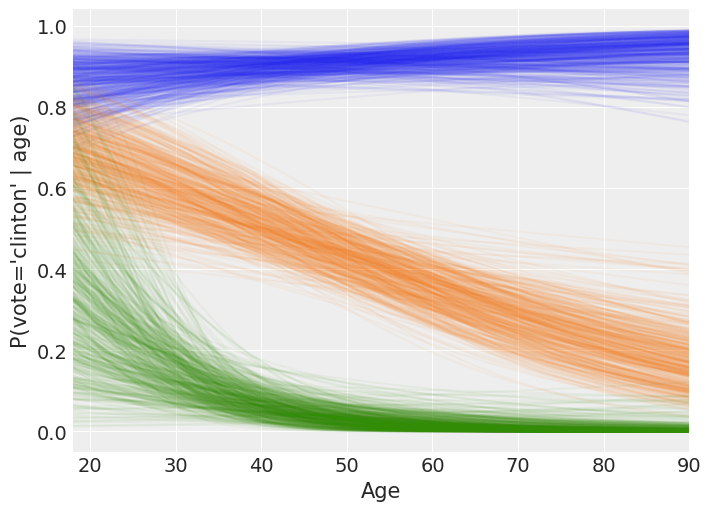

In [25]:
_, axes = plt.subplots(figsize=(7, 5))

for i in range(3):
    for t in range(500):
        axes.plot(X[:, 1], yhat[i][:, t], alpha=0.05, color=f'C{i}')
axes.set_ylabel('P(vote=\'clinton\' | age)')
axes.set_xlabel('Age', fontsize=15)
axes.set_xlim(18, 90);

The following is a rough interpretation of the information contained in the plot we've just created.

According to our logistic model, the mean probability of voting for Clinton is almost always 0.8 or greater for Democrats no matter the age. Also, the older the person, the closer the mean probability of voting Clinton to 1.

On the other hand, Republicans have a non-zero probability of voting for Clinton when they are young, but it tends to zero for older persons. We can also note the high variability of P(vote = 'Clinton') for young Republicans. This reflects our high uncertainty when estimating this probability and it is due to the small amount of Republicans in that age range plus there are only 5 Republicans out of 97 voting for Clinton in the dataset.

Finally, the mean probability of voting Clinton for the independents is around 0.7 for the youngests and decreases towards 0.2 as they get older. Since the spread of the lines is similar along all the ages, we can conclude our uncertainty in this estimate is similar for all the age groups.